<a href="https://colab.research.google.com/github/OkoksNeDam/geoinformation-data-forecasting/blob/main/mlp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Forecasting data from KEV station with MLP

## Import libraries

In [1]:
import torch
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import numpy as np
from torch import nn
from tqdm import tqdm
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.impute import KNNImputer
from IPython.display import clear_output
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import random
import os
import copy

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Seed everything

In [2]:
SEED = 42

def seed_everything(seed: int):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

seed_everything(SEED)
g = torch.Generator()
g.manual_seed(SEED)

## Install data

In [3]:
import gdown
# Main data.
data_url         = 'https://drive.google.com/drive/folders/1Pf0soKlFy21_9VADQ4hvjbMeevTdjuOW?usp=sharing'

links = [data_url]

# Downloading data.
for url in links:
    gdown.download_folder(url, quiet=True)

In [4]:
df_train, df_val, df_test = pd.read_csv('/content/data/train/train.csv'), pd.read_csv('/content/data/val/val.csv'), pd.read_csv('/content/data/test/test.csv')

In [5]:
df_train.head()

,ds,y
0,2003-01-01 01:00:00,1824.7
1,2003-01-01 02:00:00,1823.6
2,2003-01-01 03:00:00,1814.7
3,2003-01-01 04:00:00,1816.8
4,2003-01-01 05:00:00,1816.4


## Implement neural network

In [6]:
class MLP(nn.Module):
  def __init__(self, in_dim, hidden_dim, out_dim):
    super().__init__()
    self.model = nn.Sequential(
        nn.Linear(in_dim, hidden_dim),
        nn.ReLU(),
        nn.Linear(hidden_dim, hidden_dim),
        nn.ReLU(),
        nn.Linear(hidden_dim, out_dim)
    )
    self.double()

  def forward(self, X):
    return self.model(X)

## Find best method for filling missing values

Define method for fill missing values

In [7]:
def fill_missing_values(dataframe, method):
    dataframe = dataframe.copy(deep=True)
    # fill with mean.
    if method == 'mean':
        return dataframe.fillna(dataframe.mean(numeric_only=True).round(1))
    # fill with median.
    if method == 'median':
        return dataframe.fillna(dataframe.median(numeric_only=True).round(1))
    # if there are nan left, fill with bfill.
    if method == 'ffill':
        return dataframe.fillna(method=method).fillna(method='bfill')
    # filling occurs with next values.
    # if there are nan left, fill with ffill.
    if method == 'bfill':
        return dataframe.fillna(method=method).fillna(method='ffill')
    # fill with backward interpolation.
    # if there are nan left, fill with forward.
    if method == 'interpolate_backward':
        return dataframe.apply(lambda col: col.interpolate(method ='linear', limit_direction ='backward')
                                              .interpolate(method ='linear', limit_direction ='forward') if col.name != "ds" else col)
    # fill with knn method.
    if method == 'knn':
        imputer = KNNImputer(n_neighbors=15)
        dataframe = dataframe.apply(lambda col: imputer.fit_transform(col.to_numpy().reshape(-1, 1)).T[0] if col.name != "ds" else col)
        return dataframe

    return dataframe

Method to split data into sequences

In [8]:
def split_sequence(sequence, n_steps_in, n_steps_out):
  X, y = list(), list()
  for i in range(len(sequence)):
    # find the end of this pattern
    end_ix = i + n_steps_in
    out_end_ix = end_ix + n_steps_out
    # check if we are beyond the sequence
    if out_end_ix > len(sequence):
      break
    # gather input and output parts of the pattern
    seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
    X.append(seq_x)
    y.append(seq_y)
  return np.array(X), np.array(y)

Class for creating a dataset from data generated using the method <b>split_sequence</b>

In [9]:
class TSDataset(torch.utils.data.Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return (
            torch.tensor(self.x[idx, :]),
            self.y[idx],
        )

Method for calculating smape metric

In [10]:
def calc_smape(actual, predicted) -> float:

    # Convert actual and predicted to numpy
    # array data type if not already
    if not all([isinstance(actual, np.ndarray),
                isinstance(predicted, np.ndarray)]):
        actual, predicted = np.array(actual), np.array(predicted)

    return np.mean(np.abs(predicted - actual) / ((np.abs(predicted) + np.abs(actual)) / 2) ) * 100

Visualization of metrics while training

In [11]:
sns.set_style('whitegrid')
plt.rcParams.update({'font.size': 15})


def plot_metrics(train_losses, val_mape, val_smape):
    clear_output()
    fig, axs = plt.subplots(1, 2, figsize=(13, 4))
    axs[0].plot(range(1, len(train_losses) + 1), train_losses, label='train loss')
    axs[0].set_ylabel('loss')

    axs[1].plot(range(1, len(val_mape) + 1), val_mape, label='val mape')
    axs[1].plot(range(1, len(val_smape) + 1), val_smape, label='val smape')
    axs[1].set_ylabel('mape/smape')

    for ax in axs:
        ax.set_xlabel('epoch')
        ax.legend()

    plt.show()

Method for training and validating neural network

In [12]:
def train(model, criterion, optimizer, train_dataloader, val_dataloader, scheduler=None, n_epochs=5, save_models=False, saved_models_path=None):
  train_losses = []
  test_mapes = []
  test_smapes = []

  min_mape = float("inf")
  min_smape = float("inf")

  best_model = None

  for epoch in range(n_epochs):
      model.train()
      train_loss_per_epoch = 0.0
      for x_train, y_train in tqdm(train_dataloader, desc='Training'):
          x_train = x_train.to(device)
          y_train = y_train.to(device)
          y_pred = model(x_train)
          loss = criterion(y_pred, y_train)
          train_loss_per_epoch += loss.cpu()
          loss.backward()
          optimizer.step()
          optimizer.zero_grad()

      train_loss_per_epoch /= len(train_dataloader)
      train_losses += [train_loss_per_epoch.detach().numpy()]

      y_pred_arr = torch.tensor([])
      y_true_arr = torch.tensor([])
      model.eval()
      for x_val, y_val in tqdm(val_dataloader, desc='Testing'):
        with torch.no_grad():
          x_val = x_val.to(device)
          y_val = y_val.to(device)
          y_pred = model(x_val).squeeze(1)
          y_pred_arr = torch.cat((y_pred_arr, y_pred.cpu()))
          y_true_arr = torch.cat((y_true_arr, y_val.squeeze(1).cpu()))

      test_mape = mean_absolute_percentage_error(y_true_arr, y_pred_arr) * 100
      test_mapes += [test_mape]
      test_smape = calc_smape(y_true_arr, y_pred_arr)
      test_smapes += [test_smape]

      if test_mape < min_mape:
        min_mape = test_mape
        min_smape = test_smape
        best_model = copy.deepcopy(model)

      if scheduler is not None:
        scheduler.step(test_mape)

      if save_models and epoch % 2 == 0:
        model_scripted = torch.jit.script(model)
        model_scripted.save(saved_models_path + f"epoch={epoch}.pt")

      plot_metrics(train_losses, test_mapes, test_smapes)
  return min_mape, min_smape, best_model

In [13]:
def get_dataloaders_from_dataframe(train_dataframe, val_dataframe):
  X_train, y_train = split_sequence(train_dataframe.y, 1000, 1)
  X_val, y_val = split_sequence(val_dataframe.y, 1000, 1)

  train_dataset = TSDataset(X_train, y_train)
  val_dataset = TSDataset(X_val, y_val)

  train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=False)
  val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)

  return train_dataloader, val_dataloader

1. Fill NaN values with <i><b>mean</b></i> method.

In [ ]:
df_train_filled_mean = fill_missing_values(df_train, method='mean')
df_val_filled_mean = fill_missing_values(df_val, method='mean')

Scale data

In [ ]:
scaler = StandardScaler()
df_train_filled_mean.y = scaler.fit_transform(np.array(df_train_filled_mean.y).reshape(-1, 1)).T[0]
df_val_filled_mean.y = scaler.transform(np.array(df_val_filled_mean.y).reshape(-1, 1)).T[0]

Get dataloaders from train and val dataframes

In [ ]:
train_dataloader, val_dataloader = get_dataloaders_from_dataframe(df_train_filled_mean, df_val_filled_mean)

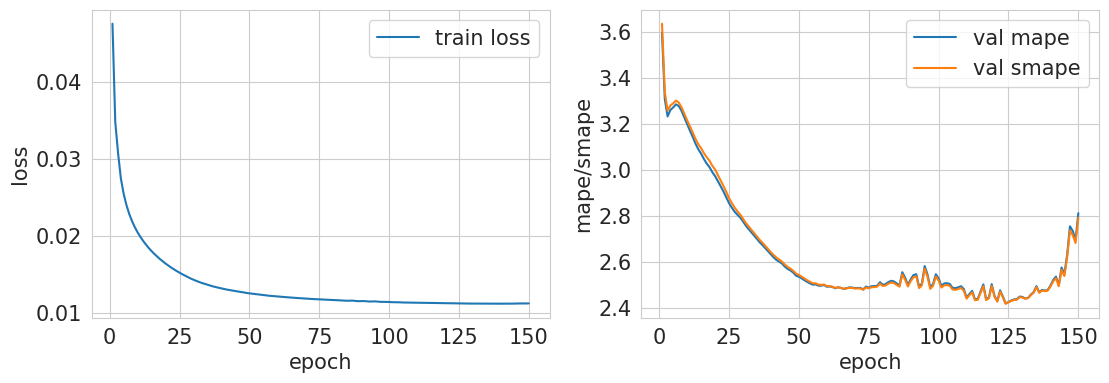

In [ ]:
torch.manual_seed(42)
NUM_EPOCHS = 150

model = MLP(1000, 128, 1).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-4, momentum=0.9)

min_mape, min_smape, best_model = train(model, criterion, optimizer, train_dataloader, val_dataloader, scheduler=None, n_epochs=NUM_EPOCHS)

In [ ]:
print(f'best mape: {round(min_mape, 4)}, best smape: {round(min_smape, 4)}')

best mape: 2.4189, best smape: 2.4177


2. Fill NaN values with <i><b>median</b></i> method.

In [ ]:
df_train_filled_median = fill_missing_values(df_train, method='median')
df_val_filled_median = fill_missing_values(df_val, method='median')

Scale data

In [ ]:
scaler = StandardScaler()
df_train_filled_median.y = scaler.fit_transform(np.array(df_train_filled_median.y).reshape(-1, 1)).T[0]
df_val_filled_median.y = scaler.transform(np.array(df_val_filled_median.y).reshape(-1, 1)).T[0]

Get dataloaders from train and val dataframes

In [ ]:
train_dataloader, val_dataloader = get_dataloaders_from_dataframe(df_train_filled_median, df_val_filled_median)

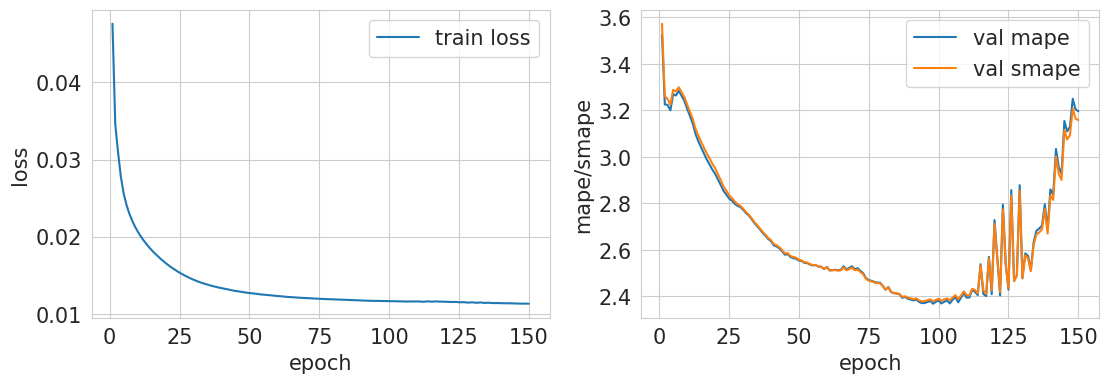

In [ ]:
torch.manual_seed(42)
NUM_EPOCHS = 150

model = MLP(1000, 128, 1).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-4, momentum=0.9)

min_mape, min_smape, best_model = train(model, criterion, optimizer, train_dataloader, val_dataloader, scheduler=None, n_epochs=NUM_EPOCHS)

In [ ]:
print(f'best mape: {round(min_mape, 4)}, best smape: {round(min_smape, 4)}')

best mape: 2.3684, best smape: 2.3785


3. Fill NaN values with <i><b>ffill</b></i> method.

In [ ]:
df_train_filled_ffill = fill_missing_values(df_train, method='ffill')
df_val_filled_ffill = fill_missing_values(df_val, method='ffill')

Scale data

In [ ]:
scaler = StandardScaler()
df_train_filled_ffill.y = scaler.fit_transform(np.array(df_train_filled_ffill.y).reshape(-1, 1)).T[0]
df_val_filled_ffill.y = scaler.transform(np.array(df_val_filled_ffill.y).reshape(-1, 1)).T[0]

Get dataloaders from train and val dataframes

In [ ]:
train_dataloader, val_dataloader = get_dataloaders_from_dataframe(df_train_filled_ffill, df_val_filled_ffill)

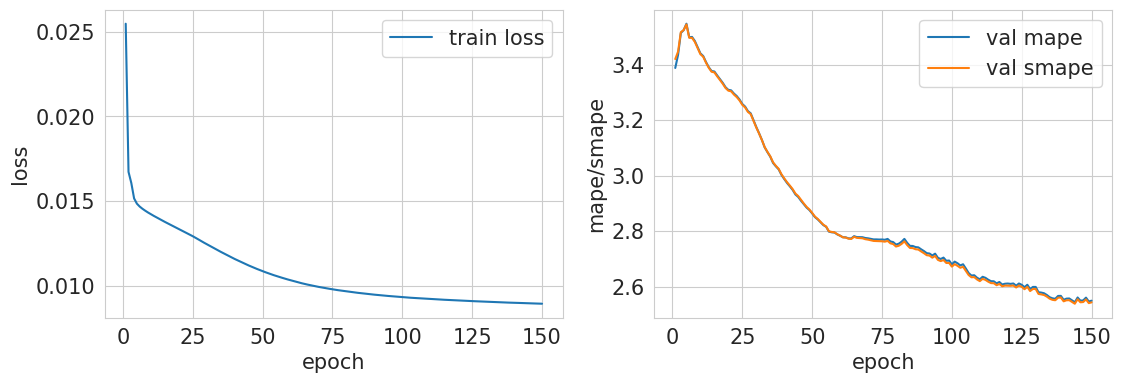

In [ ]:
torch.manual_seed(42)
NUM_EPOCHS = 150

model = MLP(1000, 128, 1).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-4, momentum=0.9)

min_mape, min_smape, best_model = train(model, criterion, optimizer, train_dataloader, val_dataloader, scheduler=None, n_epochs=NUM_EPOCHS)

In [ ]:
print(f'best mape: {round(min_mape, 4)}, best smape: {round(min_smape, 4)}')

best mape: 2.5437, best smape: 2.5384


4. Fill NaN values with <i><b>bfill</b></i> method.

In [ ]:
df_train_filled_bfill = fill_missing_values(df_train, method='bfill')
df_val_filled_bfill = fill_missing_values(df_val, method='bfill')

Scale data

In [ ]:
scaler = StandardScaler()
df_train_filled_bfill.y = scaler.fit_transform(np.array(df_train_filled_bfill.y).reshape(-1, 1)).T[0]
df_val_filled_bfill.y = scaler.transform(np.array(df_val_filled_bfill.y).reshape(-1, 1)).T[0]

Get dataloaders from train and val dataframes

In [ ]:
train_dataloader, val_dataloader = get_dataloaders_from_dataframe(df_train_filled_bfill, df_val_filled_bfill)

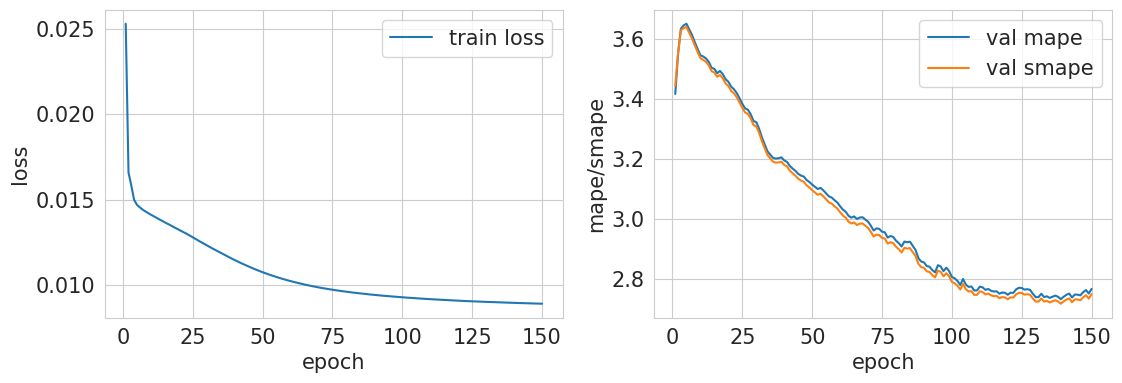

In [ ]:
torch.manual_seed(42)
NUM_EPOCHS = 150

model = MLP(1000, 128, 1).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-4, momentum=0.9)

min_mape, min_smape, best_model = train(model, criterion, optimizer, train_dataloader, val_dataloader, scheduler=None, n_epochs=NUM_EPOCHS)

In [ ]:
print(f'best mape: {round(min_mape, 4)}, best smape: {round(min_smape, 4)}')

best mape: 2.7314, best smape: 2.7163


5. Fill NaN values with <i><b>interpolate_backward</b></i> method.

In [ ]:
df_train_filled_interpolate_backward = fill_missing_values(df_train, method='interpolate_backward')
df_val_filled_interpolate_backward = fill_missing_values(df_val, method='interpolate_backward')

Scale data

In [ ]:
scaler = StandardScaler()
df_train_filled_interpolate_backward.y = scaler.fit_transform(np.array(df_train_filled_interpolate_backward.y).reshape(-1, 1)).T[0]
df_val_filled_interpolate_backward.y = scaler.transform(np.array(df_val_filled_interpolate_backward.y).reshape(-1, 1)).T[0]

Get dataloaders from train and val dataframes

In [ ]:
train_dataloader, val_dataloader = get_dataloaders_from_dataframe(df_train_filled_interpolate_backward, df_val_filled_interpolate_backward)

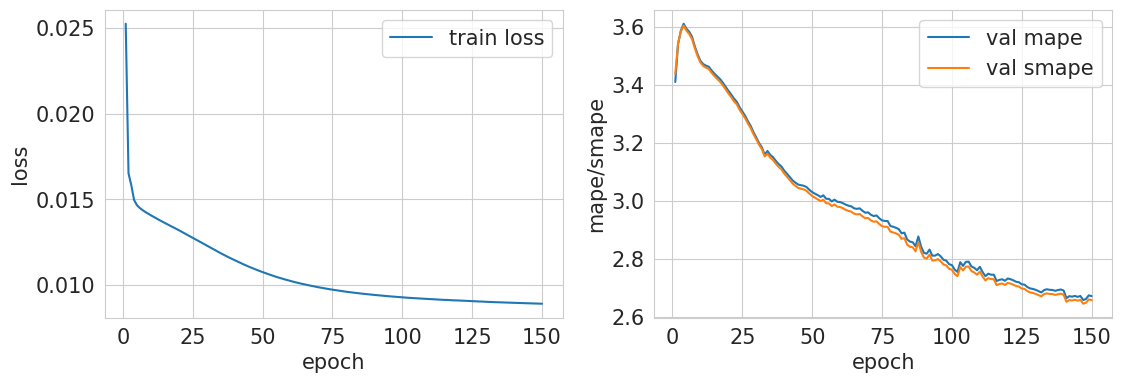

In [ ]:
torch.manual_seed(42)
NUM_EPOCHS = 150

model = MLP(1000, 128, 1).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-4, momentum=0.9)

min_mape, min_smape, best_model = train(model, criterion, optimizer, train_dataloader, val_dataloader, scheduler=None, n_epochs=NUM_EPOCHS)

In [ ]:
print(f'best mape: {round(min_mape, 4)}, best smape: {round(min_smape, 4)}')

best mape: 2.6577, best smape: 2.6449


6. Fill NaN values with <i><b>knn</b></i> method.

In [ ]:
df_train_filled_knn = fill_missing_values(df_train, method='knn')
df_val_filled_knn = fill_missing_values(df_val, method='knn')

Scale data

In [ ]:
scaler = StandardScaler()
df_train_filled_knn.y = scaler.fit_transform(np.array(df_train_filled_knn.y).reshape(-1, 1)).T[0]
df_val_filled_knn.y = scaler.transform(np.array(df_val_filled_knn.y).reshape(-1, 1)).T[0]

Get dataloaders from train and val dataframes

In [ ]:
train_dataloader, val_dataloader = get_dataloaders_from_dataframe(df_train_filled_knn, df_val_filled_knn)

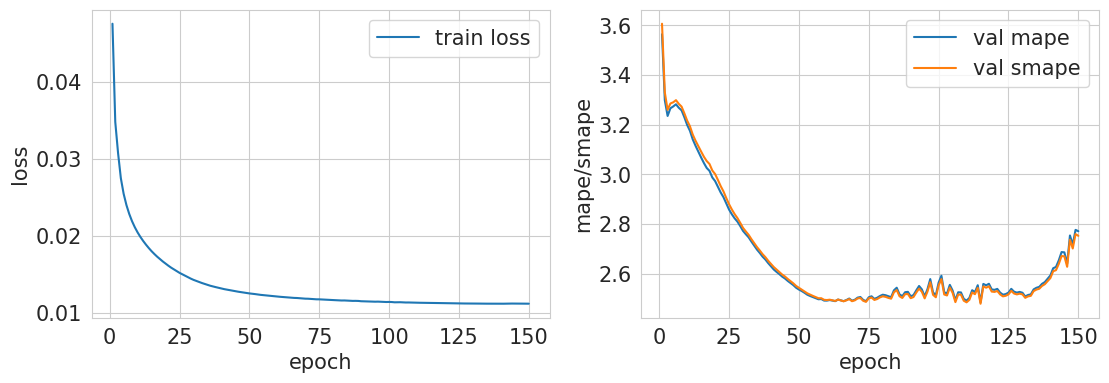

In [ ]:
torch.manual_seed(42)
NUM_EPOCHS = 150

model = MLP(1000, 128, 1).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-4, momentum=0.9)

min_mape, min_smape, best_model = train(model, criterion, optimizer, train_dataloader, val_dataloader, scheduler=None, n_epochs=NUM_EPOCHS)

In [ ]:
print(f'best mape: {round(min_mape, 4)}, best smape: {round(min_smape, 4)}')

best mape: 2.4849, best smape: 2.4794


So, the best method for filling missing values is median method with best mape: 2.3684, best smape: 2.3785

## Hyperparameter tuning

### Number of lags

1. Firstly, let's try several values of number of logs.<br>
NUM_OF_LAGS = 100

In [64]:
NUM_OF_LAGS = 100

In [65]:
df_train = fill_missing_values(df_train, method='median')
df_val = fill_missing_values(df_val, method='median')

scaler = StandardScaler()
df_train.y = scaler.fit_transform(np.array(df_train.y).reshape(-1, 1)).T[0]
df_val.y = scaler.transform(np.array(df_val.y).reshape(-1, 1)).T[0]

X_train, y_train = split_sequence(df_train.y, NUM_OF_LAGS, 1)
X_val, y_val = split_sequence(df_val.y, NUM_OF_LAGS, 1)

train_dataset = TSDataset(X_train, y_train)
val_dataset = TSDataset(X_val, y_val)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=False)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)

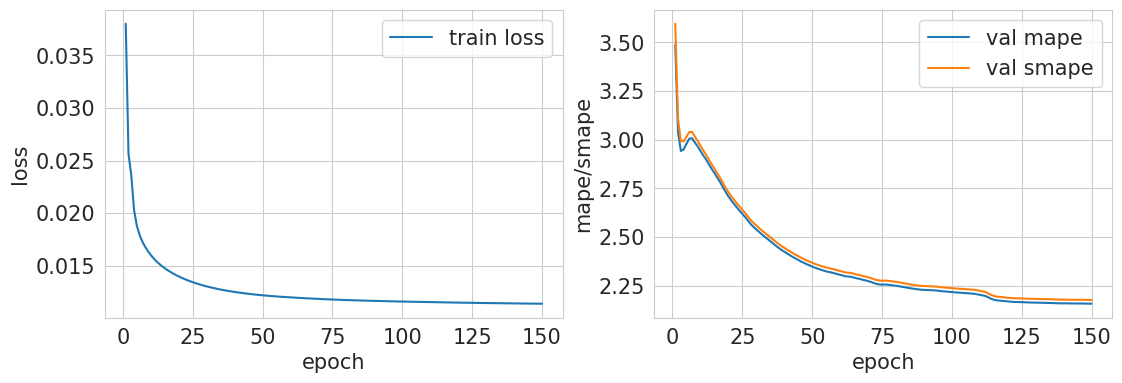

best mape: 2.1589, best smape: 2.1778


In [66]:
torch.manual_seed(42)

HIDDEN_LAYER_SIZE = 128
NUM_EPOCHS = 150
LEARNING_RATE = 1e-4
MOMENTUM = 0.9
PREDICTION_PERIOD = 1

model = MLP(NUM_OF_LAGS, HIDDEN_LAYER_SIZE, PREDICTION_PERIOD).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)

min_mape, min_smape, best_model = train(model, criterion, optimizer, train_dataloader, val_dataloader, scheduler=None, n_epochs=NUM_EPOCHS)
print(f'best mape: {round(min_mape, 4)}, best smape: {round(min_smape, 4)}')

2. NUM_OF_LAGS = 500

In [52]:
NUM_OF_LAGS = 500

In [53]:
df_train = fill_missing_values(df_train, method='median')
df_val = fill_missing_values(df_val, method='median')

scaler = StandardScaler()
df_train.y = scaler.fit_transform(np.array(df_train.y).reshape(-1, 1)).T[0]
df_val.y = scaler.transform(np.array(df_val.y).reshape(-1, 1)).T[0]

X_train, y_train = split_sequence(df_train.y, NUM_OF_LAGS, 1)
X_val, y_val = split_sequence(df_val.y, NUM_OF_LAGS, 1)

train_dataset = TSDataset(X_train, y_train)
val_dataset = TSDataset(X_val, y_val)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=False)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)

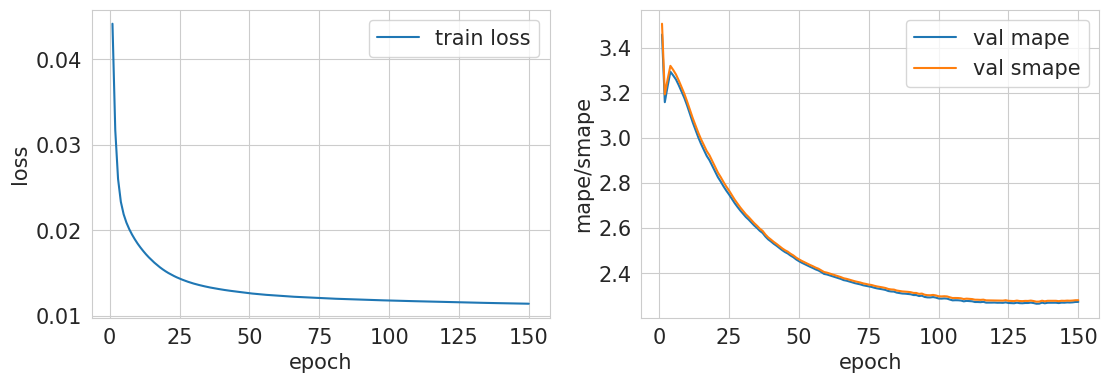

best mape: 2.2647, best smape: 2.2739


In [55]:
torch.manual_seed(42)

HIDDEN_LAYER_SIZE = 128
NUM_EPOCHS = 150
LEARNING_RATE = 1e-4
MOMENTUM = 0.9
PREDICTION_PERIOD = 1

model = MLP(NUM_OF_LAGS, HIDDEN_LAYER_SIZE, PREDICTION_PERIOD).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)

min_mape, min_smape, best_model = train(model, criterion, optimizer, train_dataloader, val_dataloader, scheduler=None, n_epochs=NUM_EPOCHS)
print(f'best mape: {round(min_mape, 4)}, best smape: {round(min_smape, 4)}')

A lag number of 1000 was considered when trying to find the best method for filling gaps in the data. The result showed best mape: 2.3684, best smape: 2.3785. Best number of lags - 100.

### Hidden size

An experiment with a hidden layer size of 128 has already been carried out during the search for the best number of lags, results: best mape: 2.1589, best smape: 2.177

1. HIDDEN_LAYER_SIZE = 32

In [84]:
HIDDEN_LAYER_SIZE = 32
NUM_OF_LAGS = 100

In [85]:
df_train = fill_missing_values(df_train, method='median')
df_val = fill_missing_values(df_val, method='median')

scaler = StandardScaler()
df_train.y = scaler.fit_transform(np.array(df_train.y).reshape(-1, 1)).T[0]
df_val.y = scaler.transform(np.array(df_val.y).reshape(-1, 1)).T[0]

X_train, y_train = split_sequence(df_train.y, NUM_OF_LAGS, 1)
X_val, y_val = split_sequence(df_val.y, NUM_OF_LAGS, 1)

train_dataset = TSDataset(X_train, y_train)
val_dataset = TSDataset(X_val, y_val)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=False)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)

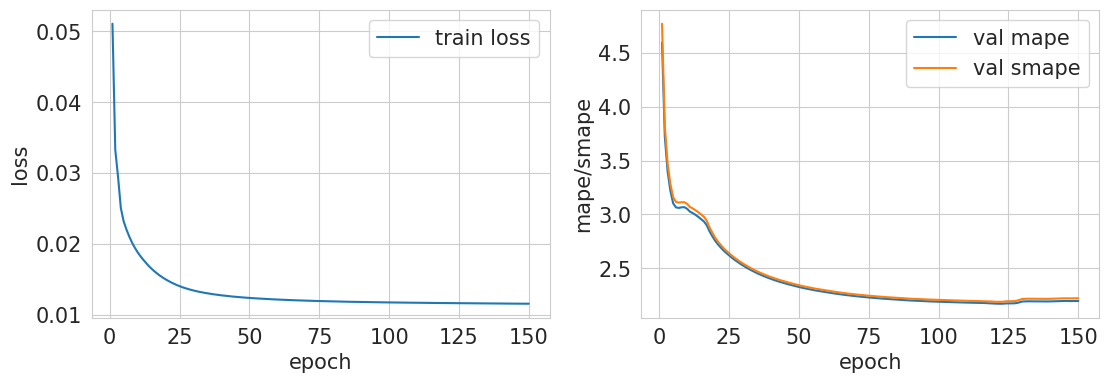

best mape: 2.1705, best smape: 2.1885


In [86]:
torch.manual_seed(42)

NUM_EPOCHS = 150
LEARNING_RATE = 1e-4
MOMENTUM = 0.9
PREDICTION_PERIOD = 1

model = MLP(NUM_OF_LAGS, HIDDEN_LAYER_SIZE, PREDICTION_PERIOD).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)

min_mape, min_smape, best_model = train(model, criterion, optimizer, train_dataloader, val_dataloader, scheduler=None, n_epochs=NUM_EPOCHS)
print(f'best mape: {round(min_mape, 4)}, best smape: {round(min_smape, 4)}')

2. HIDDEN_LAYER_SIZE = 1024

In [81]:
HIDDEN_LAYER_SIZE = 1024
NUM_OF_LAGS = 100

In [82]:
df_train = fill_missing_values(df_train, method='median')
df_val = fill_missing_values(df_val, method='median')

scaler = StandardScaler()
df_train.y = scaler.fit_transform(np.array(df_train.y).reshape(-1, 1)).T[0]
df_val.y = scaler.transform(np.array(df_val.y).reshape(-1, 1)).T[0]

X_train, y_train = split_sequence(df_train.y, NUM_OF_LAGS, 1)
X_val, y_val = split_sequence(df_val.y, NUM_OF_LAGS, 1)

train_dataset = TSDataset(X_train, y_train)
val_dataset = TSDataset(X_val, y_val)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=False)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)

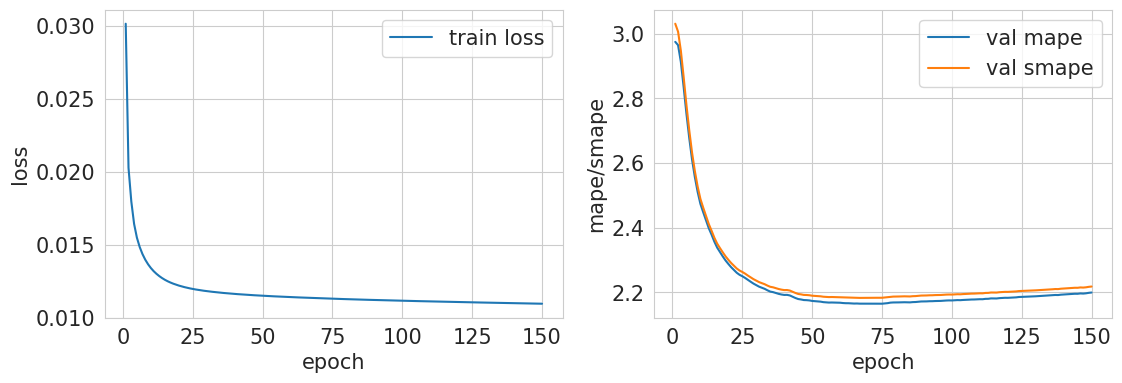

best mape: 2.1644, best smape: 2.1828


In [83]:
torch.manual_seed(42)

NUM_EPOCHS = 150
LEARNING_RATE = 1e-4
MOMENTUM = 0.9
PREDICTION_PERIOD = 1

model = MLP(NUM_OF_LAGS, HIDDEN_LAYER_SIZE, PREDICTION_PERIOD).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)

min_mape, min_smape, best_model = train(model, criterion, optimizer, train_dataloader, val_dataloader, scheduler=None, n_epochs=NUM_EPOCHS)
print(f'best mape: {round(min_mape, 4)}, best smape: {round(min_smape, 4)}')

## Testing

In [77]:
df_test_filled_median = fill_missing_values(df_test, method='median')
df_test_filled_median.y = scaler.transform(np.array(df_test_filled_median.y).reshape(-1, 1)).T[0]

X_test, y_test = split_sequence(df_test_filled_median.y, 100, 1)

test_dataset = TSDataset(X_test, y_test)

test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

In [78]:
y_pred_arr = torch.tensor([])
y_true_arr = torch.tensor([])
for x_val, y_val in test_dataloader:
  with torch.no_grad():
    x_val = x_val.to(device)
    y_val = y_val.to(device)
    y_pred = best_model(x_val).squeeze(1)
    loss = nn.MSELoss()(y_pred, y_val.squeeze(1))
    y_pred_arr = torch.cat((y_pred_arr, y_pred.cpu()))
    y_true_arr = torch.cat((y_true_arr, y_val.squeeze(1).cpu()))

In [ ]:
len(y_pred_arr), len(y_true_arr)

(17212, 17212)

In [79]:
mean_squared_error(y_true_arr, y_pred_arr), mean_absolute_percentage_error(y_true_arr, y_pred_arr) * 100, calc_smape(y_true_arr, y_pred_arr)

(0.018643501619775613, 2.737338776556051, 2.765280230166744)

(2.565607210056397, 2.5919027555678706)

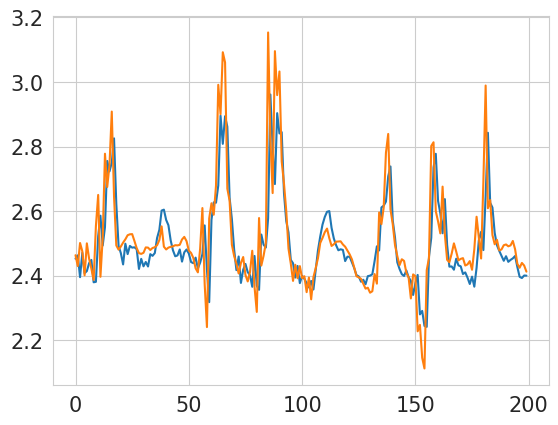

In [80]:
s = slice(3000, 3200)
a = 0
plt.plot(y_pred_arr[s] + a)
plt.plot(y_true_arr[s] + a)
mean_absolute_percentage_error(y_true_arr[s] + a, y_pred_arr[s] + a) * 100, calc_smape(y_true_arr[s] + a, y_pred_arr[s] + a)

In [ ]:
data_for_pred = torch.tensor(df_val.y[:1000])
y_pred_arr = torch.tensor([])
y_true_arr = torch.tensor([])
for i in range(df_val.shape[0] - 1000):
  with torch.no_grad():
    y_pred = model(data_for_pred)
    y_pred_arr = torch.cat((y_pred_arr, y_pred))
    y_true_arr = torch.cat((y_true_arr, torch.tensor(df_val.y[i + 1000]).unsqueeze(0)))
    data_for_pred = data_for_pred[1:]
    data_for_pred = torch.cat((data_for_pred, y_true_arr[-1].unsqueeze(0)))

In [ ]:
mean_squared_error(y_true_arr, y_pred_arr), mean_absolute_percentage_error(y_true_arr, y_pred_arr) * 100, calc_smape(y_true_arr, y_pred_arr)

(0.009909205769520982, 2.40816809305625, 2.410352727071574)